$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 2: Ridge Regression with K-Fold Cross-Validation

Daniel Ball

## Overview

## Method

### Initial Setup and Function Definitions
Here we initialize pyplot and numpy. We also define the following functions:
   - makeLambda: creates a DxD identity matrix with index 0,0 equal to 0
   - train: determines weights given X, T, and lambda
   - use: applies the model to an input matrix X and returns a prediction of the test values
   - rmse: returns a scalar error indicating the similarity of the test to the prediction. Lower is better.
   - partitionKFolds: generator function. Each successive call returns a new assignment train, test, and validation partitions of the input matrix X.

In [2]:
# Initial Setup
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
np.set_printoptions(suppress=True)
%matplotlib inline
%precision 4

'%.4f'

In [4]:
def train(X,T,lamb):
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.insert( (X - means)/stds, 0, 1, axis=1)
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( Xs1.T @ Xs1 + lambDiag, Xs1.T @ T)[0]
    return {'w': w, 'means':means, 'stds':stds}

In [5]:
'''
X is an input data set to which we wish to apply the model
model is a dictionary containing:
    'w': weights for the model
    'stds': standard deviations for each column in the model
    'means': means for each column in the model
Returns a vector of predicted values given X
'''
def use(model, X):
    # standardize the input matrix X based on the model's mean and standard deviation
    Xs = (X - model['means']) / model['stds']    
    # add the vector of 1's for the bias
    Xs1 = np.hstack((np.ones((Xs.shape[0],1)), Xs))
    
    # apply the model and return the resulting vector
    # each index in the vector is a prediction for the age for the corresponding row in X
    prediction = np.dot(Xs1, model['w'])
    return prediction

def rmse(A,B):
    return np.sqrt(np.mean( (A-B)**2 ))

In [6]:
def partitionKFolds(X,T,nFolds,shuffle=False,nPartitions=3):
    '''Usage: for Xtrain,Ttrain,Xval,Tval,Xtest,Ttext in partitionKFolds(X,T,5):'''
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    for testFold in range(nFolds):
        if nPartitions == 3:
            # Repeat with validateFold taking each single fold, except for the testFold
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue
                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    a,b = startsStops[tf]                
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]
                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]
                # Construct Xtest and Ttest
                a,b = startsStops[testFold]
                rows = rowIndices[a:b]
                Xtest = X[rows,:]
                Ttest = T[rows,:]
                # Return partition matrices, then suspend until called again.
                yield Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest,testFold
        else:
            # trainFolds are all remaining folds, after selecting test and validate folds
            trainFolds = np.setdiff1d(range(nFolds), [testFold])
            # Construct Xtrain and Ttrain by collecting rows for all trainFolds
            rows = []
            for tf in trainFolds:
                a,b = startsStops[tf]                
                rows += rowIndices[a:b].tolist()
            Xtrain = X[rows,:]
            Ttrain = T[rows,:]
            # Construct Xtest and Ttest
            a,b = startsStops[testFold]
            rows = rowIndices[a:b]
            Xtest = X[rows,:]
            Ttest = T[rows,:]
            # Return partition matrices, then suspend until called again.
            yield Xtrain,Ttrain,Xtest,Ttest,testFold

In [7]:
def getLambdaResults(Xtrain, Ttrain, Xval, Tval, Xtest, Ttest, lamb):
    model = train(Xtrain, Ttrain, lamb)
    predict = {
        'Xtrain': use(model, Xtrain),
        'Xval':   use(model, Xval),
        'Xtest':  use(model, Xtest)    
    }
    errors = {
        'Xtrain': rmse(predict['Xtrain'], Ttrain),
        'Xval':   rmse(predict['Xval'], Tval),
        'Xtest':  rmse(predict['Xtest'], Ttest)    
    }
    return {'model':model, 'predict':predict, 'errors':errors}

In [8]:
def getMultipleResults(X, T, nFolds, lambdas=[0]):
    foldCount = 0
    results = []
    for Xtrain,Ttrain,Xval,Tval,Xtest,Ttest,_ in partitionKFolds(X,T,nFolds, shuffle=True):
        for lamb in lambdas:           
            thisResult = getLambdaResults(Xtrain, Ttrain, Xval, Tval, Xtest, Ttest, lamb)
            predict = thisResult['predict']
            errors = thisResult['errors']
            model = thisResult['model']
            results.append( [ foldCount, lamb, errors['Xtrain'], errors['Xval'], errors['Xtest']])
        foldCount += 1
    return np.array(results)

In [9]:
def multipleLambdas(X, T, nFolds, lambdas=[0]):
    results = getMultipleResults(X, T, nFolds, lambdas)
    bestResults = []
    for fold in range(nFolds):
        foldResults = results[results[:,0] == fold]
        bestResult = np.argmin(foldResults, axis=0)[3]
        bestResults.append( foldResults[bestResult, :])
    return np.array(bestResults)

Here is some simple example data.  Play with this a bit.  Try different definitions of the target matrix `T`.

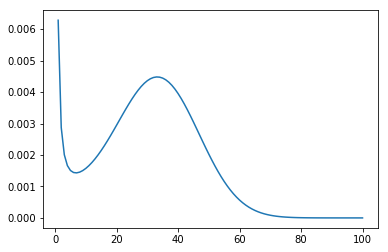

In [10]:
X = np.linspace(1,100,100).reshape((-1,1))
T = (1/X**1.5)*np.exp(-((X-40)**2)/300) # now there's a fun function!
plt.plot(X,T)

In [11]:
results = multipleLambdas(X,T,10,range(0,40,5))
results

array([[  0.    ,   0.    ,   0.0011,   0.0011,   0.0012],
       [  1.    ,   0.    ,   0.0011,   0.0011,   0.0012],
       [  2.    ,  25.    ,   0.0012,   0.0009,   0.0013],
       [  3.    ,  10.    ,   0.0011,   0.0012,   0.0013],
       [  4.    ,  15.    ,   0.0012,   0.001 ,   0.0013],
       [  5.    ,  15.    ,   0.0011,   0.0014,   0.0013],
       [  6.    ,   0.    ,   0.0012,   0.0009,   0.0012],
       [  7.    ,   0.    ,   0.0012,   0.0008,   0.0013],
       [  8.    ,   0.    ,   0.0011,   0.0014,   0.0012],
       [  9.    ,   0.    ,   0.0011,   0.0012,   0.0011]])

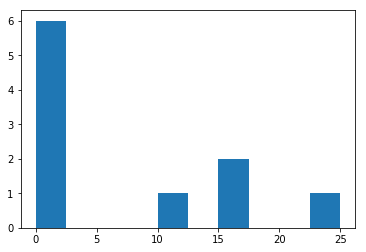

In [12]:
plt.hist(results[:,1]);

Your results will not be identical to the example above.  In fact, your results will differ each time you run these cells because the `partitionKFolds` function shuffles the order of the samples before forming the partitions.

## Data

This section contains 
- the data chosen for the experiment
- the procedure used to process the data for input to the modeling functions

### Source

The data chosen is Abalone Data from the <a href="http://archive.ics.uci.edu/ml/datasets/Abalone">UC Irvine Machine Learning Repository</a>. The data set originated from a prior study by Nash et. al[1].

<table>
<tr><th>Name</th> <th>Data Type</th> <th>Meas.</th> <th>Description</th></tr>
<tr><td>Sex				</td><td>nominal	</td><td>		</td><td>M, F, and I (infant)</td></tr>
<tr><td>Length			</td><td>continuous	</td><td>mm		</td><td>Longest shell measurement</td></tr>
<tr><td>Diameter		</td><td>continuous	</td><td>mm		</td><td>perpendicular to length</td></tr>
<tr><td>Height			</td><td>continuous	</td><td>mm		</td><td>with meat in shell</td></tr>
<tr><td>Whole weight	</td><td>continuous	</td><td>grams	</td><td>whole abalone</td></tr>
<tr><td>Shucked weight	</td><td>continuous	</td><td>grams	</td><td>weight of meat</td></tr>
<tr><td>Viscera weight	</td><td>continuous	</td><td>grams	</td><td>gut weight (after bleeding)</td></tr>
<tr><td>Shell weight	</td><td>continuous	</td><td>grams	</td><td>after being dried</td></tr>
<tr><td>Rings			</td><td>integer	</td><td>		</td><td>+1.5 gives the age in years</td></tr>
</table>

I use the Rings, Whole weight, Shucked Weight, Viscera Weight, and Shell Weight as my data. I restrict my samples to Male abalone, in the hopes that it will give a more uniform correlation between weight and rings.

First, we pull in the data from the source, abalone.data. While the file is given the .data extension, examination shows it to be formatted as comma separated values. There are no missing or unusual values so there is no need for extra processing of the input.

We will use numpy.loadtxt to read the file. The gender column needs a converter to change the gender to a float. We need to create 3 new columns for gender as booleans. First we need to convert these to numbers when the file is read.

The file is organized with data stored in row vectors and there is no header row, so we specify the comma delimiter and read the file. Since there are three genders, we separate the gender into three boolean columns. Additionally, we add 1.5 to the rings column since the names file states that age is rings + 1.5.

In [1]:
# function for creating an integer from gender column
def genderCheck(gender):
    if ord(gender) == ord('M'):
        return 1
    if ord(gender) == ord('F'):
        return 2
    if ord(gender) == ord('I'):
        return 3
    return 0

# retrieve data from text
rawData = np.loadtxt('abalone.data',delimiter=',', usecols=(0,4,5,6,7,8), converters={0: genderCheck})

# parse gender into three arrays of binary values
mMask = (rawData[:,0] == 1).reshape(-1,1)
fMask = (rawData[:,0] == 2).reshape(-1,1)
iMask = (rawData[:,0] == 3).reshape(-1,1)

# concatenate arrays with the the input data sliced to remove gender
splitGenders = np.hstack((mMask, fMask, iMask, rawData[:,1:]))

# add 1.5 to the rings column to get ages
splitGenders[:,7] += 1.5

NameError: name 'np' is not defined

In [ ]:
# concatenate arrays with the the input data sliced to remove gender
splitGenders = np.hstack((mMask, fMask, iMask, rawData[:,1:]))

# add 1.5 to the rings column to get ages
splitGenders[:,7] += 1.5

In [ ]:
ages = splitGenders[:,7]
completeData = splitGenders[:,3:7]

mData = completeData[splitGenders[:,0] == 1]
fData = completeData[splitGenders[:,1] == 1]
iData = completeData[splitGenders[:,2] == 1]
mTest = ages[splitGenders[:,0] == 1]
fTest = ages[splitGenders[:,1] == 1]
iTest = ages[splitGenders[:,2] == 1]
names = ['whole weight', 'schucked weight', 'viscera weight', 'shell weight']  

plt.figure(figsize=(12,12))
nrow,ncol = mData.shape
for c in range(ncol):
    plt.subplot(4,4,c+1)
    plt.scatter(mData[:,c], mTest, alpha=0.2, label='male', color='red')
    plt.xlabel(names[c])
    plt.scatter(fData[:,c], fTest, alpha=0.2, label='female', color='blue')
    plt.xlabel(names[c])
    plt.scatter(iData[:,c], iTest, alpha=0.2, label='infant', color='green')
    plt.xlabel(names[c])
    plt.ylabel('age')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.tight_layout(h_pad=5)

The data is likely not linear, but it does appear to fit with other biological statistics. The majority of ages fit in a certain area. I believe this makes sense. As abalone reach adulthood, they will stay near a single weight. A small portion are larger than average, a small portion are smaller than average. If genders were split out, I suspect more infants will be in the bottom of the "cone" and more adults will be near the larger mass of points. We can see that infants are both younger (abalone are born at a very young age) and lighter than their developed counterparts. While females are capable of reaching sizes as large as males, males seem to have a greater average weight and females seem like they may have a higher average age than males.

## Results
Following are results from the abalone data. While it was recommended that I use a different sample set, I opted for this one again because I wanted to see how the lambda would affect my data and to see what other insight I could gain into the development of the model. I choose a random sample of 50 points to represent novel data and use the bestResults from multipleLambdas() to choose lambdas and generate weights.

In [ ]:
# create shorthands for train and test arrays and get the best lambdas.
X = splitGenders[:,:7]
T = splitGenders[:,7:8] # range for second column preserves 2nd dimension in shape
bestResults = multipleLambdas(X, T, 10 , lambdas=np.arange(0,20,.2))
bestLambdas = bestResults[:,1]

In [ ]:
# get frequency of lambda values in bestResults
values, counts = np.unique(bestLambdas, return_counts=True)
lambdaFrequency = np.stack((values,counts)).T
print("{:<10s} {:<10s}".format('lambda', 'count'))
for l,c in lambdaFrequency:
    print("{:<10.2f} {:<10.0f}".format(l,c))

# Lambda Histogram
This shows a histogram of optimum lambdas for the $10*9 = 90$ possible partitionings of the data given a 10 fold partitioning. 

In [2]:
ax = plt.hist(bestResults[:,1])

NameError: name 'plt' is not defined

From the histogram, we clearly see that a clear majority of the lambdas resolved to 0, indicating no penalty for weights.

### Plot with $\lambda = 0$ and $\lambda = 19.8$
While the most common lambda was $\lambda = 0$, a not insignificant number of results had an optimum of $ \lambda = 19.8$, so we will plot both and observe the differences. We will also plot with a very large value of $\lambda = 10^9$, to plot a near linear fit, as well as $\lambda = 15$ as a "poor" fit with a more reasonable penalty.

In [ ]:
# generate models
m0 = train(X, T, 0)
mInf = train(X, T, 10**9)
m15 = train(X, T, 19.8)
m198 = train(X, T, 19.8)

# create a novel sampling of the data
sampleSize = 50
sampleIndices = np.array(range(X.shape[0]))
np.random.shuffle(sampleIndices)
sampleIndices = sampleIndices[:sampleSize]
sampleX = X[sampleIndices]
sampleT = T[sampleIndices]

In [ ]:
# get predicted values with the given model over the sample indices
predict0 = use(m0, sampleX)
predict198 = use(m198, sampleX)
predict15 = use(m15, sampleX)
predictInf = use(mInf, sampleX)

In [ ]:
Xs1 = np.hstack((np.ones((sampleX.shape[0],1)), sampleX))
plt.plot(sampleT, 'ro', lw=5, alpha=.5)
plt.plot(Xs1 @ m0['w'], label = '0')
plt.plot(Xs1 @ m198['w'], label = '19.8')
plt.plot(Xs1 @ m15['w'], label = '15')
plt.plot(Xs1 @ mInf['w'], label = '10^9')
plt.ylabel("Age")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.);

It is interesting to me how close some of the points are. The overall trend of the prediction is a horizontal mean, but many of the predictions are very near what appear to be outliers. It's interesting to me that the model finds "older" outliers more accurately than "younger" ones (values below the average seem to have fewer correct predictions than values above average). I believe this is likely due to the more clustered data for younger and (infant) abalone which can be seen by the "cornucopia" shape of the data plots.

### Error Trends with Lambda
It is apparent that the three models viewed near the lower end of the lambda scale have a similar trend and likely similar RMSEs. here we will plot the RMSE against lambda for an exponential range of lambdas.

In [ ]:
lambs = [10**i for i in np.arange(-2,9.1,.1)]
results = getMultipleResults(X, T, 5 , lambdas=lambs)
minValErrors = []
for lamb in lambs:
    lambGroup = results[results[:,1] == lamb]
    mins = np.argmin(lambGroup, axis=0)
    minValErrors.append(lambGroup[mins[4], 4])

minIndex = np.argmin(minValErrors)
minLambda = lambs[minIndex]
minError = minValErrors[minIndex]
plt.semilogx(lambs, minValErrors)
plt.plot([minLambda],[minError], 'ro')
plt.ylabel('Minimum Validation RMSE')
plt.xlabel('Lambda');

This graph shows a plot of minimum validation RMSEs obtained from a 5 fold partitioning with lambda ranging from $10^{-2}$ to $10^{9}$ on a semilog plot. This demonstrates the general behavior of the model with respect to lambda. The red dot marks the minimum. Different runs will shift the dot within the "valley" of the graph, typically between 0 and 10. This shows that any value of lambda less than approximately 10 will give a model more accurate than the simple mean. As lambda grows to approximately $10^6$, the error grows until finally reaching a point where lambda is approximating the average rather than a linear model.

In [ ]:
%run -i "A2grader.py"